You might need to install this on your system:

apt-get install python3-opencv git

In [1]:
import os
#"""
# !rm k -r
if not os.path.isdir('k'):
 !git clone -b development12 https://github.com/joaopauloschuler/k-neural-api.git k
else:
 !cd k && git pull
#"""
!cd k && pip install .

Cloning into 'k'...
remote: Enumerating objects: 1349, done.
remote: Counting objects: 100% (798/798), done.
remote: Compressing objects: 100% (512/512), done.
remote: Total 1349 (delta 587), reused 491 (delta 285), pack-reused 551
Receiving objects: 100% (1349/1349), 15.00 MiB | 16.92 MiB/s, done.
Resolving deltas: 100% (943/943), done.
Processing /content/k
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for cai: filename=cai-0.1.4-py3-none-any.whl size=56793 sha256=1116053e3527366f3e4c1bfb3f01f5cbb5ea8376a46acc9f0ba37ec69806aa1d
  Stored in directory: /tmp/pip-ephem-wheel-cache-xx_x2o6a/wheels/c1/8a/57/56dbba25eff58e52e536543

In [2]:
import cai.layers
import cai.datasets
import cai.models
import cai.mobilenet_v3
import numpy as np
from tensorflow import keras
from tensorflow.keras import mixed_precision
import gc
import multiprocessing
import random
import tensorflow as tf
print("Tensorflow version:", tf.version.VERSION)
print("Keras version:", keras.__version__)
print("CPU cores:", multiprocessing.cpu_count())
import psutil
print('RAM:', (psutil.virtual_memory().total / 1e9),'GB')
print(tf.config.list_physical_devices('GPU'))
import matplotlib.pylab as plt
from sklearn.metrics import classification_report

Tensorflow version: 2.7.0
Keras version: 2.7.0
CPU cores: 8
RAM: 54.76702208 GB
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
!nvidia-smi

Wed Nov 10 17:34:46 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    22W / 300W |      2MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
mixed_precision.set_global_policy('mixed_float16')

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla V100-SXM2-16GB, compute capability 7.0


In [5]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [6]:
from tensorflow.python.profiler.model_analyzer import profile
from tensorflow.python.profiler.option_builder import ProfileOptionBuilder

def get_flops(model):
  forward_pass = tf.function(
      model.call,
      input_signature=[tf.TensorSpec(shape=(1,) + model.input_shape[1:])])

  graph_info = profile(forward_pass.get_concrete_function().graph,
                          options=ProfileOptionBuilder.float_operation())

  # The //2 is necessary since `profile` counts multiply and accumulate
  # as two flops, here we report the total number of multiply accumulate ops
  flops = graph_info.total_float_ops // 2
  return flops

# Create folder structure with CIFAR-10 as png files.

In [7]:
verbose=True
root_folder = 'cifar10-as-png'
data_dir = root_folder + '/train';
test_dir = root_folder + '/test';

x_train, y_train, x_test, y_test = cai.datasets.load_dataset(tf.keras.datasets.cifar10, verbose=verbose, lab=False, bipolar=False)

if not os.path.isdir(root_folder):
  os.mkdir(root_folder)
  cai.datasets.save_dataset_as_png(cai.datasets.fix_bad_tfkeras_channel_order(x_train)*255, y_train, dest_folder_name=data_dir)
  cai.datasets.save_dataset_as_png(cai.datasets.fix_bad_tfkeras_channel_order(x_test)*255, y_test, dest_folder_name=test_dir)

170508288/170498071 [==============================] - 6s 0us/step
train shape (50000, 32, 32, 3)
test shape (10000, 32, 32, 3)
Original channel  0  min: 0.0  max: 255.0
Original channel  1  min: 0.0  max: 255.0
Original channel  2  min: 0.0  max: 255.0
Loading RGB.
Channel  0  min: 0.0  max: 1.0
Channel  1  min: 0.0  max: 1.0
Channel  2  min: 0.0  max: 1.0


In [8]:
num_classes = 10
batch_size = 64
epochs = 50
target_size_x = 224
target_size_y = 224
seed = 12

In [9]:
train_datagen = cai.util.create_image_generator(validation_split=0.1, rotation_range=20, width_shift_range=0.3, height_shift_range=0.3, channel_shift_range=0.0, rescale=1./255)
test_datagen = cai.util.create_image_generator_no_augmentation(rescale=1./255)
cpus_num = max([multiprocessing.cpu_count(), 8])

def cyclical_adv_lrscheduler25(epoch):
    """CAI Cyclical and Advanced Learning Rate Scheduler.
    # Arguments
        epoch: integer with current epoch count.
    # Returns
        float with desired learning rate.
    """
    base_learning = 0.001
    local_epoch = epoch % 25
    if local_epoch < 7:
       return base_learning * (1 + 0.5*local_epoch)
    else:
       return (base_learning * 4) * ( 0.85**(local_epoch-7) )

In [10]:
def work_on_kmobilenet(show_model=False, run_fit=False, test_results=False, calc_f1=False):
  monitor='val_accuracy'
  if (calc_f1): 
    test_results=True
  if (show_model):
    input_shape = (target_size_x, target_size_y, 3)
  else:
    input_shape = (None, None, 3)
  for kType in [2]:
      basefilename = '/content/drive/MyDrive/output/JP36B12-mobilenet-CIFAR10-'+str(kType)
      best_result_file_name = basefilename+'-best_result.hdf5'
      print('Running: '+basefilename)
      if kType == -1:
        model = cai.mobilenet_v3.MobileNetV3Large(
          input_shape=input_shape,
          alpha=1.0,
          minimalistic=False,
          include_top=True,
          input_tensor=None,
          classes=num_classes,
          pooling=None,
          dropout_rate=0.2)
      else:
        model = cai.mobilenet_v3.kMobileNetV3Large(
          input_shape=input_shape,
          alpha=1.0,
          minimalistic=False,
          include_top=True,
          input_tensor=None,
          classes=num_classes,
          pooling=None,
          dropout_rate=0.2,
          kType=kType)

      optimizer = keras.optimizers.RMSprop()
      optimizer = mixed_precision.LossScaleOptimizer(optimizer)
      model.compile(
        loss='categorical_crossentropy',
        optimizer=optimizer,
        metrics=['accuracy'])

      if (show_model):
        model.summary(line_length=180)
        print('model flops:',get_flops(model))

      save_best = keras.callbacks.ModelCheckpoint(
            filepath=best_result_file_name,
            monitor=monitor,
            verbose=1,
            save_best_only=True,
            save_weights_only=False,
            mode='max',
            save_freq='epoch')

      if (run_fit):
        train_flow = train_datagen.flow_from_directory(
            directory=data_dir,
            subset="training",
            target_size=(target_size_x, target_size_y),
            color_mode="rgb",
            batch_size=batch_size,
            class_mode="categorical",
            shuffle=True,
            seed=seed
        )
        validation_flow = train_datagen.flow_from_directory(
            directory=data_dir,
            subset="validation",
            target_size=(target_size_x, target_size_y),
            color_mode="rgb",
            batch_size=batch_size,
            class_mode="categorical",
            shuffle=True,
            seed=seed
        )
        history = model.fit(
          x = train_flow,
          epochs=epochs,
          batch_size=batch_size,
          validation_data=validation_flow,
          callbacks=[save_best, tf.keras.callbacks.LearningRateScheduler(cyclical_adv_lrscheduler25)],
          workers=cpus_num,
          max_queue_size=128
          )
        plt.figure()
        plt.ylabel("Accuracy (training and validation)")
        plt.xlabel("Epochs")
        plt.ylim([0,1])
        plt.plot(history.history["accuracy"])
        plt.plot(history.history["val_accuracy"])
      if (test_results):
        test_flow = test_datagen.flow_from_directory(
            directory=test_dir,
            target_size=(target_size_x, target_size_y),
            color_mode="rgb",
            batch_size=batch_size,
            class_mode="categorical",
            shuffle=True,
            seed=seed
        )
        print('Best Model Results: '+best_result_file_name)
        model = cai.models.load_kereas_model(best_result_file_name)
        evaluated = model.evaluate(
            x=test_flow,
            batch_size=batch_size,
            use_multiprocessing=False,
            workers=cpus_num
        )
        for metric, name in zip(evaluated,["loss","acc"]):
              print(name,metric)
      if (calc_f1):
        pred_y = model.predict(x_test)
        print("Predicted Shape:", pred_y.shape)
        pred_classes_y = np.array(list(np.argmax(pred_y, axis=1)))
        test_classes_y = np.array(list(np.argmax(y_test, axis=1)))
        print("Pred classes shape:",pred_classes_y.shape)
        print("Test classes shape:",test_classes_y.shape)
        report = classification_report(test_classes_y, pred_classes_y, digits=4)
        print(report)
      print('Finished: '+basefilename)

# Show Models

In [11]:
work_on_kmobilenet(show_model=True, run_fit=False, test_results=False)

Running: /content/drive/MyDrive/output/JP36B12-mobilenet-CIFAR10-2
Model: "kMobilenetV3large-2"
____________________________________________________________________________________________________________________________________________________________________________________
 Layer (type)                                              Output Shape                            Param #              Connected to                                                
 input_1 (InputLayer)                                      [(None, 224, 224, 3)]                   0                    []                                                          
                                                                                                                                                                                    
 Conv_pad (ZeroPadding2D)                                  (None, 225, 225, 3)                     0                    ['input_1[0][0]']                                           

# Fitting

Running: /content/drive/MyDrive/output/JP36B12-mobilenet-CIFAR10-2
Found 45000 images belonging to 10 classes.
Found 5000 images belonging to 10 classes.
Epoch 1/50
704/704 [==============================] - ETA: 0s - loss: 1.6273 - accuracy: 0.3965
Epoch 00001: val_accuracy improved from -inf to 0.10000, saving model to /content/drive/MyDrive/output/JP36B12-mobilenet-CIFAR10-2-best_result.hdf5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


704/704 [==============================] - 278s 310ms/step - loss: 1.6273 - accuracy: 0.3965 - val_loss: 2.3788 - val_accuracy: 0.1000 - lr: 0.0010
Epoch 2/50
704/704 [==============================] - ETA: 0s - loss: 1.2820 - accuracy: 0.5386
Epoch 00002: val_accuracy did not improve from 0.10000
704/704 [==============================] - 215s 304ms/step - loss: 1.2820 - accuracy: 0.5386 - val_loss: 2.6547 - val_accuracy: 0.1000 - lr: 0.0015
Epoch 3/50
704/704 [==============================] - ETA: 0s - loss: 1.1066 - accuracy: 0.6086
Epoch 00003: val_accuracy improved from 0.10000 to 0.10140, saving model to /content/drive/MyDrive/output/JP36B12-mobilenet-CIFAR10-2-best_result.hdf5
704/704 [==============================] - 217s 307ms/step - loss: 1.1066 - accuracy: 0.6086 - val_loss: 2.8489 - val_accuracy: 0.1014 - lr: 0.0020
Epoch 4/50
704/704 [==============================] - ETA: 0s - loss: 0.9898 - accuracy: 0.6561
Epoch 00004: val_accuracy improved from 0.10140 to 0.20180, sa

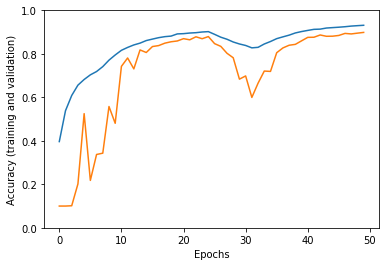

In [12]:
work_on_kmobilenet(show_model=False, run_fit=True, test_results=True)

# Test Results

In [13]:
work_on_kmobilenet(show_model=False, run_fit=False, test_results=True)

Running: /content/drive/MyDrive/output/JP36B12-mobilenet-CIFAR10-2
Found 10000 images belonging to 10 classes.
Best Model Results: /content/drive/MyDrive/output/JP36B12-mobilenet-CIFAR10-2-best_result.hdf5
157/157 [==============================] - 17s 63ms/step - loss: 0.2477 - accuracy: 0.9274
loss 0.24768933653831482
acc 0.9273999929428101
Finished: /content/drive/MyDrive/output/JP36B12-mobilenet-CIFAR10-2
